*Task 3: Customer Segmentation / Clustering*

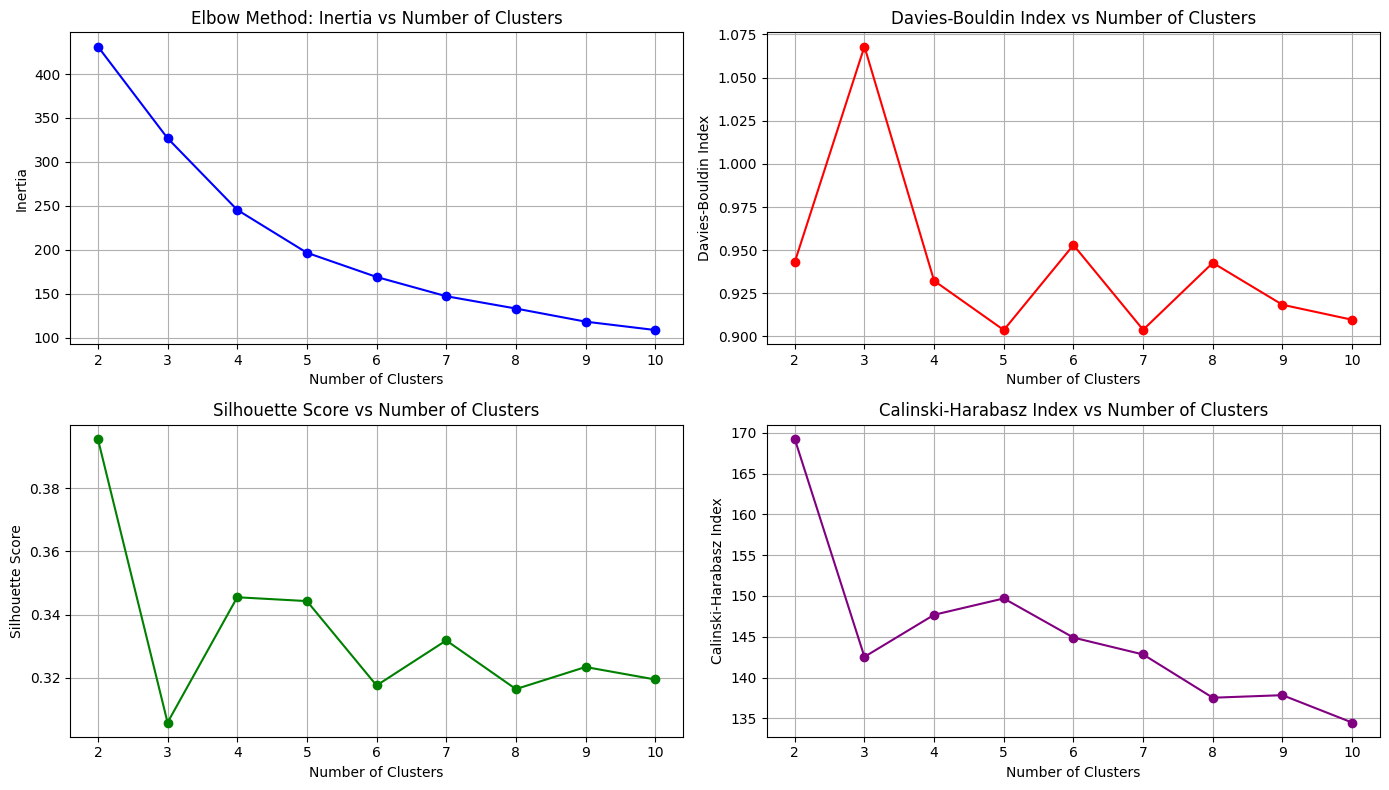

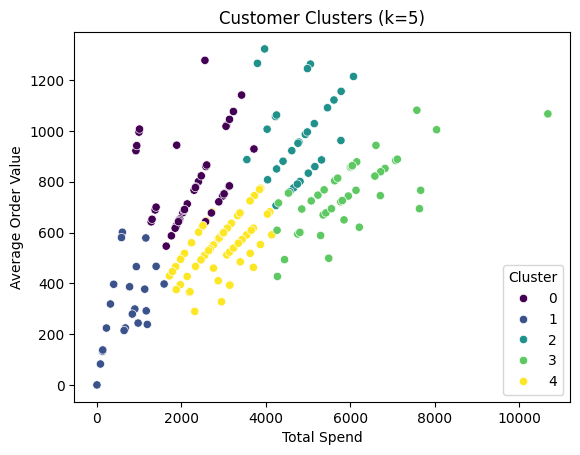

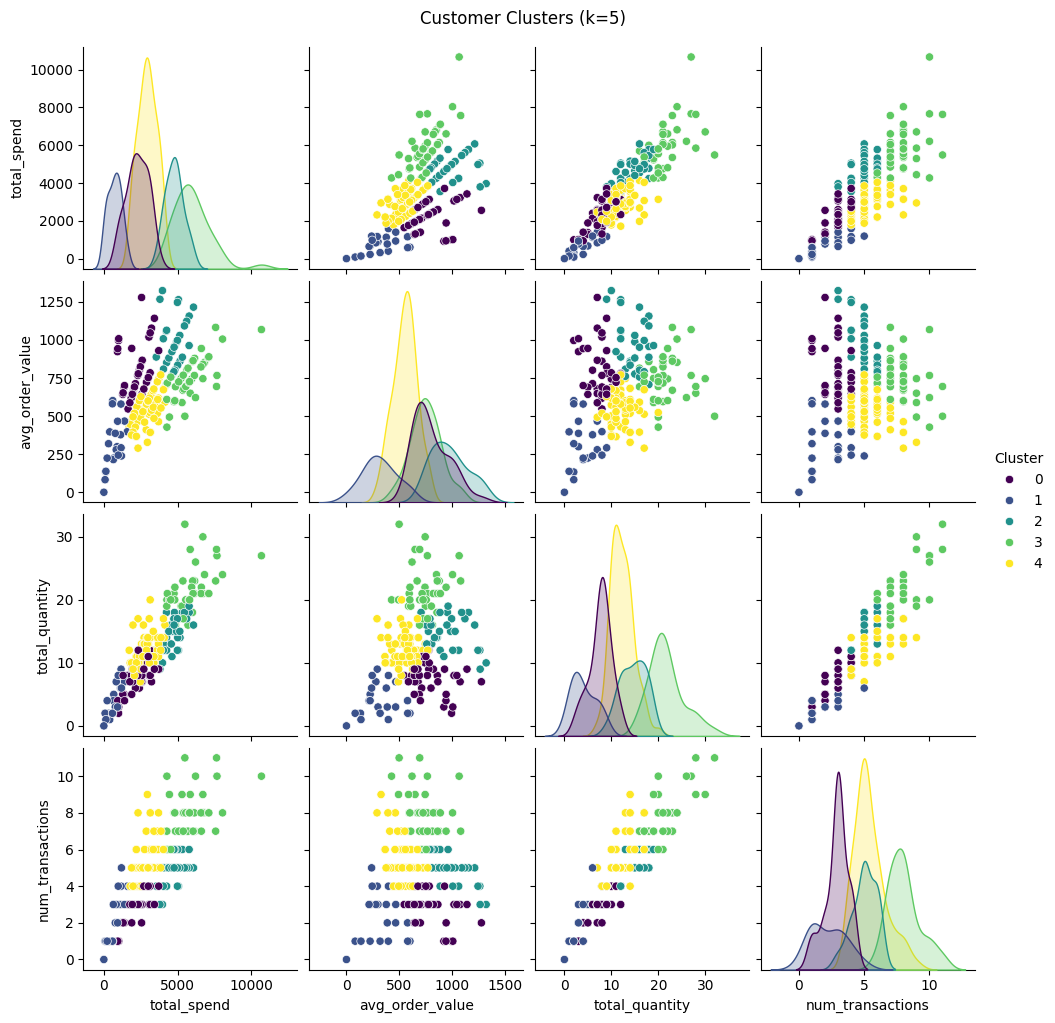

Optimal Number of Clusters: 5
Davies-Bouldin Index: 0.9037161528635442
Silhouette Score: 0.34425772238047814
Calinski-Harabasz Index: 149.6952743938583


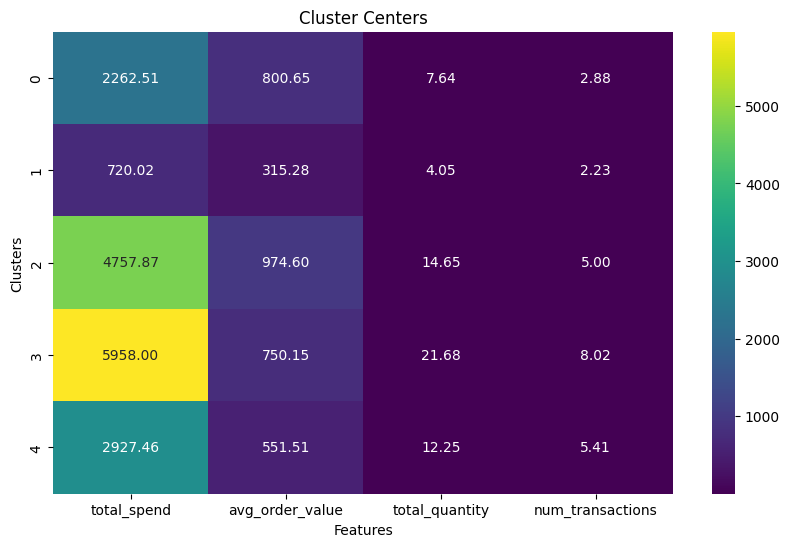

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ["OMP_NUM_THREADS"] = "1"
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
def prepare_customer_data(customers, transactions):
    customer_summary = transactions.groupby('CustomerID').agg(
        total_spend=('TotalValue', 'sum'),
        avg_order_value=('TotalValue', 'mean'),
        total_quantity=('Quantity', 'sum'),
        num_transactions=('TransactionID', 'count')
    ).reset_index()
    customer_profile = customers.merge(customer_summary, on='CustomerID', how='left').fillna(0)
    return customer_profile
customer_profile = prepare_customer_data(customers, transactions)
features = ['total_spend', 'avg_order_value', 'total_quantity', 'num_transactions']
customer_profile[features] = customer_profile[features].replace([np.inf, -np.inf], np.nan)
customer_profile[features] = customer_profile[features].fillna(0)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile[features])
def evaluate_clustering(k_values, scaled_features):
    inertia = []
    db_indexes = []
    silhouette_scores_list = []
    ch_scores = []  # Calinski-Harabasz index
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        cluster_labels = kmeans.fit_predict(scaled_features)
        
        db_index = davies_bouldin_score(scaled_features, cluster_labels)
        silhouette_score_value = silhouette_score(scaled_features, cluster_labels)
        ch_score = calinski_harabasz_score(scaled_features, cluster_labels)
        
        inertia.append(kmeans.inertia_)
        db_indexes.append(db_index)
        silhouette_scores_list.append(silhouette_score_value)
        ch_scores.append(ch_score)
    
    return inertia, db_indexes, silhouette_scores_list, ch_scores
k_values = range(2, 11)
inertia, db_indexes, silhouette_scores_list, ch_scores = evaluate_clustering(k_values, scaled_features)
def plot_clustering_metrics(k_values, inertia, db_indexes, silhouette_scores_list, ch_scores):
    plt.figure(figsize=(14, 8))

    # Elbow Method: Inertia
    plt.subplot(2, 2, 1)
    plt.plot(k_values, inertia, marker='o', color='b')
    plt.title('Elbow Method: Inertia vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)

    # Davies-Bouldin Index
    plt.subplot(2, 2, 2)
    plt.plot(k_values, db_indexes, marker='o', color='r')
    plt.title('Davies-Bouldin Index vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Index')
    plt.grid(True)

    # Silhouette Score
    plt.subplot(2, 2, 3)
    plt.plot(k_values, silhouette_scores_list, marker='o', color='g')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)

    # Calinski-Harabasz Index
    plt.subplot(2, 2, 4)
    plt.plot(k_values, ch_scores, marker='o', color='purple')
    plt.title('Calinski-Harabasz Index vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Calinski-Harabasz Index')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_clustering_metrics(k_values, inertia, db_indexes, silhouette_scores_list, ch_scores)
optimal_clusters = np.argmin(db_indexes) + 2  # +2 to match the range from k=2 to k=10
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_features)
db_index_optimal = davies_bouldin_score(scaled_features, customer_profile['Cluster'])
silhouette_score_optimal = silhouette_score(scaled_features, customer_profile['Cluster'])
ch_score_optimal = calinski_harabasz_score(scaled_features, customer_profile['Cluster'])
sns.scatterplot(x=customer_profile['total_spend'], y=customer_profile['avg_order_value'], hue=customer_profile['Cluster'], palette='viridis')
plt.title(f'Customer Clusters (k={optimal_clusters})')
plt.xlabel('Total Spend')
plt.ylabel('Average Order Value')
plt.legend(title='Cluster')
plt.show()
sns.pairplot(customer_profile, hue='Cluster', vars=features, palette='viridis')
plt.suptitle(f'Customer Clusters (k={optimal_clusters})', y=1.02)
plt.show()
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {db_index_optimal}")
print(f"Silhouette Score: {silhouette_score_optimal}")
print(f"Calinski-Harabasz Index: {ch_score_optimal}")
def plot_cluster_centers(kmeans, features, customer_profile):
    centers = kmeans.cluster_centers_
    centers = scaler.inverse_transform(centers)  # Reverse scaling for original values
    cluster_centers_df = pd.DataFrame(centers, columns=features)

    plt.figure(figsize=(10, 6))
    sns.heatmap(cluster_centers_df, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Cluster Centers')
    plt.xlabel('Features')
    plt.ylabel('Clusters')
    plt.show()

plot_cluster_centers(kmeans, features, customer_profile)

customer_profile[['CustomerID', 'Cluster']].to_csv('Clustering.csv', index=False)